<b style="color: red;">TODO </b>
1) Add signatures from dataset1 to dataset2 mainly related to background color <br>
2) Understand how to setup tensorflow GPU. Currently using Tensorflow CPU

<p style="color: red;">
Tensor flow install error

  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
ERROR: catboost 0.24.4 requires plotly, which is not installed.
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.4.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.4.1 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
ERROR: astroid 2.3.3 has requirement wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.
Installing collected packages: six, absl-py, gast, grpcio, numpy, oauthlib, requests-oauthlib, rsa, cachetools, google-auth, google-auth-oauthlib, tensorboard-plugin-wit, wheel, tensorboard, wrapt, typing-extensions, keras-preprocessing, astunparse, opt-einsum, tensorflow-estimator, flatbuffers, tensorflow-cpu
  Attempting uninstall: six

</p>

<b>Tuning </b><p>
layer.trainable = True yields around ~77% accuracy

To try
1) Increase input shape to higher than 224   ==> imageDimensions = (224,224,3)=77%   (512,224,3)= <br> 
2) Add one more FC Layer ===> 4096 did not help <br>
3) Try Resnet<br>

VGG16 and VGG19 - yields similar performance.
    
</p>

Trying retraining all layers instead of using exsisting weights. 78% accuracy!!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import pandas as pd
import numpy as np

In [ ]:
#imageDimensions = (224,224,3)
imageDimensions = (224,224,3)

<b>Utility functions</b>

In [ ]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_png(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, imageDimensions[:-1])
    return image

In [ ]:
def preprocess_triplets_train( anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """
    print(">>> Anchor", anchor)

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [ ]:
def preprocess_triplets(personId, anchor, positive, negative, isGenuine):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """
    print(">>> Anchor", anchor)

    return (
        personId,
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
        isGenuine
    )

In [ ]:
# def triplet_loss(y_true, y_pred):
#     alpha = 0.5
#     anchor, positive, negative =y_pred[0,0:512], y_pred[0,512:1024], y_pred[0,1024:1536]
    
#     positive_distance = K.mean(K.square(anchor - positive),axis=-1)
#     negative_distance = K.mean(K.square(anchor - negative),axis=-1)
#     return K.mean(K.maximum(0.0, positive_distance - negative_distance + alpha))

In [ ]:
# def getImage(basePath, typeOfData, dfRec, imageDimensions):
#     img_path = basePath + "/" + typeOfData + "/" + dfRec["relPath"] + "/" + dfRec["fileName"]
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (imageDimensions[1],imageDimensions[0]), interpolation=cv2.INTER_CUBIC)
#     #img = img/255 - resulted in a drop in accuracy
#     #preprocess_input(img)
#     return img;

In [ ]:
def visualize(images_dataset):
    """Visualize a few triplets from the supplied batches."""

    def showImages(ax, image):
        for i in range(3):
            ax[i].imshow(image[i])
            ax[i].get_xaxis().set_visible(False)
            ax[i].get_yaxis().set_visible(False)

    rows = len(images_dataset)
    images = list(images_dataset.as_numpy_iterator())
    fig, axs = plt.subplots(rows,3, sharex=True, sharey=True, figsize=(500,500))
    for x in range(rows):
         anchor, positive, negative = images[x][0],images[x][1],images[x][2]
         showImages(axs[x], (anchor, positive, negative))


In [ ]:
# def dataGenerator(df, typeOfData):
#     personIds = df["personId"].unique()
#     for p in personIds:
#         genuine = df[(df.personId==p) & (df.Genuine==1)]
#         forg = df[(df.personId==p) & (df.Genuine==0)]
#         anchor_img = getImage(basePath, typeOfData, genuine.iloc[0], imageDimensions) # Use first row as anchor
#         for g in genuine[1:].index:
#             pos_img= getImage(basePath, typeOfData, genuine.loc[g], imageDimensions) 
#             for f in forg.index:
#                 neg_img =  getImage(basePath, typeOfData, forg.loc[f], imageDimensions)
#                 #yield(np.array([anchor_img, pos_img, neg_img]), np.array([0]))
#                 print (type(anchor_img),type(pos_img), type(neg_img), np.array([0]))
#                 print (anchor_img.shape,pos_img.shape, neg_img.shape, np.array([0]))
#                 #yield([np.array(anchor_img), np.array(pos_img), np.array(neg_img)], np.array([0]))
#                 #yield([np.array(anchor_img), np.array(pos_img), np.array(neg_img)],np.array([0]))
#                 yield([anchor_img, pos_img, neg_img], 0)

<b> Load training and test data </b>

In [ ]:
basePath = "/notebooks/capstone/dataset/dataset2/sign_data"
data_train = pd.read_csv(basePath + "/train/train_clean.csv")
data_train.sort_values(by="personId", inplace=True)
print(data_train.head())
print(data_train.shape)

In [ ]:
data_test = pd.read_csv(basePath + "/test/test_clean.csv")
data_test.sort_values(by="personId", inplace=True)
print(data_test.head(20))
print(data_test.shape)

<b>Prepare training data</b>

In [ ]:
def categorizeImages(df, typeOfData):
    personIds = df["personId"].unique()
    anchor_imgs = []
    postive_imgs = []
    negative_imgs = []
    for p in personIds:
        genuine = df[(df.personId==p) & (df.Genuine==1)]
        forg = df[(df.personId==p) & (df.Genuine==0)]
        anchor_img = basePath+"/"+typeOfData+"/"+genuine.iloc[0].relPath + "/"+genuine.iloc[0].fileName  
        for g in genuine[1:].index:
            pos_img= basePath+"/"+typeOfData+"/"+genuine.loc[g].relPath + "/"+genuine.loc[g].fileName  
            for f in forg.index:
                neg_img =  basePath+"/"+typeOfData+"/"+forg.loc[f].relPath + "/"+forg.loc[f].fileName  
                anchor_imgs.append(anchor_img)
                postive_imgs.append(pos_img)
                negative_imgs.append(neg_img)
    
    return anchor_imgs,postive_imgs,negative_imgs

In [ ]:
#anchor_dataset,positive_dataset,negative_dataset = tf.data.Dataset.from_generator(generator=categorizeImages(data_train, "train"))
anchor_images,positive_images,negative_images = categorizeImages(data_train, "train")

In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset  = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset  = tf.data.Dataset.from_tensor_slices(negative_images)
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets_train)


In [ ]:
# Let's now split our dataset in train and validation.
image_count = len(anchor_dataset)
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

In [ ]:
#visualize(train_dataset.take(5))

In [ ]:
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

<b>Prepare Test data set</b>

In [ ]:
#Compare each positive each positive in the set and and each negative against all other positives
def categorizeTestImages(df, typeOfData):
    personIds = df["personId"].unique()
    anchor_imgs = []
    postive_imgs = []
    toCompare_imgs = []
    isGenuine = []
    personId = []
    for p in personIds:
        genuine = df[(df.personId==p) & (df.Genuine==1)]
        forg = df[(df.personId==p) & (df.Genuine==0)]
        anchor_img = basePath+"/"+typeOfData+"/"+genuine.iloc[0].relPath + "/"+genuine.iloc[0].fileName  
        for g in genuine[1:].index:
            pos_img= basePath+"/"+typeOfData+"/"+genuine.loc[g].relPath + "/"+genuine.loc[g].fileName  
            #Compare this with all forgeries
            for f in forg.index:
                toCompareImg =  basePath+"/"+typeOfData+"/"+forg.loc[f].relPath + "/"+forg.loc[f].fileName 
                personId.append(p)
                anchor_imgs.append(anchor_img)
                postive_imgs.append(pos_img)
                toCompare_imgs.append(toCompareImg)
                isGenuine.append(False)
                
            # Compare current postive with all other positives besides the anchor
            for f in genuine[1:].index:
                toCompareImg =  basePath+"/"+typeOfData+"/"+genuine.loc[f].relPath + "/"+genuine.loc[f].fileName  
                if ( pos_img != toCompareImg):
                    personId.append(p)
                    anchor_imgs.append(anchor_img)
                    postive_imgs.append(pos_img)
                    toCompare_imgs.append(toCompareImg)
                    isGenuine.append(True)    
    return personId, anchor_imgs,postive_imgs,toCompare_imgs, isGenuine

In [ ]:
tst_personId, tst_anchor_images,tst_positive_images,tst_toCompare_imgs, tst_isGenuine = categorizeTestImages(data_test, "test")

In [ ]:
print(len(tst_personId))
print(len(tst_anchor_images))
print(len(tst_positive_images))
print(len(tst_toCompare_imgs))
print(len(tst_isGenuine))

In [ ]:
tst_personId_dataset = tf.data.Dataset.from_tensor_slices(tst_personId)
tst_anchor_dataset = tf.data.Dataset.from_tensor_slices(tst_anchor_images)
tst_positive_dataset  = tf.data.Dataset.from_tensor_slices(tst_positive_images)
tst_toCompare_imgs_dataset  = tf.data.Dataset.from_tensor_slices(tst_toCompare_imgs)
tst_isGenuine_dataset  = tf.data.Dataset.from_tensor_slices(tst_isGenuine)

tst_dataset = tf.data.Dataset.zip((tst_personId_dataset, tst_anchor_dataset, tst_positive_dataset, tst_toCompare_imgs_dataset, tst_isGenuine_dataset ))
##dataset = dataset.shuffle(buffer_size=1024)
tst_dataset = tst_dataset.map(preprocess_triplets)
len(tst_dataset)

In [ ]:
#visualize(tst_dataset.take(5))


<b>Prepare Model Architecture</b>
Setting up the embedding generator model

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=imageDimensions, include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
#     if layer.name == "conv5_block1_out":     ##TODO: Why only this layer?
#         trainable = True
    layer.trainable = trainable

In [ ]:
embedding.summary()

<B>Setting up the Siamese Network model</B>

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=imageDimensions)
positive_input = layers.Input(name="positive", shape=imageDimensions)
negative_input = layers.Input(name="negative", shape=imageDimensions)

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),   ##TODO : What is pre-process input do here?
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances  ##TODO: Not clear what Output does here?
)

<b> Train Model </b>
<p>We now need to implement a model with custom training loop so we can compute the triplet loss using the three embeddings produced by the Siamese network.</p>

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

         
    def _compute_loss_sq(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    
#     def _compute_loss_cos(self, data):
#         cosine_similarity = metrics.CosineSimilarity()
#         sitive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
#         print("Positive similarity:", positive_similarity)
#         negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
#         print("Negative similarity", negative_similarity)
#         loss = tf.math.squared_difference(positive_similarity, negative_similarity)
#         loss = tf.maximum(loss + self.margin, 0.0)
#         #tf.math.squared_difference
#         return loss

    def _compute_loss(self, data):
        return self._compute_loss_sq(data)
    
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0000001))
siamese_model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=early_stop)

#Tuning
# Image dimension=448, margin=0.5 epoch 1, norestraining of weights,Adam=0.0001, loss=2.1
# Image dimension=224, margin=0.5 epoch 1, norestraining of weights,Adam=0.0001, loss=0.05
# Image dimension=224, margin=0.5 epoch 1, norestraining of weights,Adam=0.0001, lossFn=cos, loss=? 
# Image dimension=224, margin=10 epoch 1, norestraining of weights,Adam=0.0001, loss=0.5
# Image dimension=224, margin=0.5 epoch 1, norestraining of weights, Adam=0.00001 instead of 0.0001 loss=?**  0.000001 - 0.0020 - val_loss: 0.0095
# Image dimension=112, margin=0.5 epoch 1, norestraining of weights,Adam=0.0001, loss=0.17

In [ ]:
filename = '/notebooks/capstone/models/embeddings-res32'
filename2 = '/notebooks/capstone/models/siamesenetwork-res32'

In [ ]:
# embedding.save(filename)
# siamese_network.save(filename2)

In [ ]:
##Load model
embedding = tf.keras.models.load_model(filename)

In [ ]:
siamese_network = tf.keras.models.load_model(filename2)

<b>Testing</b>

Inspecting what the network has learned
At this point, we can check how the network learned to separate the embeddings depending on whether they belong to similar images.

We can use cosine similarity to measure the similarity between embeddings.

Let's pick a sample from the dataset to check the similarity between the embeddings generated for each image.

Finally, we can compute the cosine similarity between the anchor and positive images and compare it with the similarity between the anchor and the negative images.

We should expect the similarity between the anchor and positive images to be larger than the similarity between the anchor and the negative images.

In [ ]:
tst_dataset = tst_dataset.batch(1, drop_remainder=False)

In [ ]:
sample = next(iter(tst_dataset))
personId, anchor, positive, toCompare, isGenuine = sample
print(f"PersonId: %s anchor: %d positive: %d toCompare: %d isGenuine %s" % (personId.numpy(), len(anchor), len(positive), len(toCompare),isGenuine.numpy()))


In [ ]:
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(toCompare)),
)

In [ ]:
print(f"PersonId: %d anchor: %d positive: %d toCompare: %d isGenuine %d" % (len(personId), len(anchor), len(positive), len(toCompare),len(isGenuine)))

Finally, we can compute the cosine similarity between the anchor and positive images and compare it with the similarity between the anchor and the negative images.

We should expect the similarity between the anchor and positive images to be larger than the similarity between the anchor and the negative images.

In [ ]:
def compareEmbeds(personId, anchor_embedding, positive_embedding, negative_embedding, isGenuine):
    cosine_similarity = metrics.CosineSimilarity()

    positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
    #print("Positive similarity:", positive_similarity.numpy())

    negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
    #print("Negative similarity", negative_similarity.numpy())
    return (personId.numpy(), positive_similarity.numpy(), negative_similarity.numpy(), (positive_similarity.numpy() - negative_similarity.numpy()), isGenuine.numpy())

In [ ]:
print (compareEmbeds(personId,anchor_embedding, positive_embedding, negative_embedding, isGenuine))

In [ ]:
def getEmbeddings(row):
    personId, anchor, positive, toCcompare, isGenuine = row
    return (
        personId.numpy(), 
        embedding(resnet.preprocess_input(anchor)),
        embedding(resnet.preprocess_input(positive)),
        embedding(resnet.preprocess_input(toCcompare)),
        isGenuine.numpy()
    )

In [ ]:
## Save the embeddings
tst_embedding_data = [getEmbeddings(row) for row in iter(tst_dataset)]
tst_data_embeddings_df = pd.DataFrame(columns=["personId", "anchor_embedding", "positive_embedding","negative_embedding","isGenuine"], data=tst_embedding_data)
tst_data_embeddings_df.head(1)

In [6]:
import pickle
pFile_embeddings = "/notebooks/capstone/results_embeddings.pickle"

In [ ]:
# with open(pFile_embeddings, 'wb') as file:
#     pickle.dump(tst_data_embeddings_df, file)

In [7]:
with open(pFile_embeddings, 'rb') as file:
    df = pickle.load(file)
df.shape

(5038, 5)

In [8]:
df.columns

Index(['personId', 'anchor_embedding', 'positive_embedding',
       'negative_embedding', 'isGenuine'],
      dtype='object')

<b>Approach 1</b>: Compare the relative distance of positive and negative related to Anchor

In [13]:
def compareEmbeds(personId, anchor_embedding, positive_embedding, negative_embedding, isGenuine):
    cosine_similarity = metrics.CosineSimilarity()

    positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
    #print("Positive similarity:", positive_similarity.numpy())

    negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
    #print("Negative similarity", negative_similarity.numpy())
    return (positive_similarity.numpy(), negative_similarity.numpy(), (positive_similarity.numpy() - negative_similarity.numpy()))

In [14]:
df2 = df.apply(lambda row: compareEmbeds(row.personId, row.anchor_embedding, row.positive_embedding, row.negative_embedding, row.isGenuine), axis=1,  result_type='expand')
df2.columns = ["Pos", "Neg", "Diff"]
df2.head(3)

,0,1,2
0,0.992328,0.970792,0.021536
1,0.992328,0.990692,0.001636
2,0.992328,0.978380,0.013948
3,0.992328,0.972754,0.019574
4,0.992328,0.970110,0.022218
...,...,...,...
5033,0.996557,0.994285,0.002272
5034,0.996557,0.997044,-0.000487
5035,0.996557,0.996651,-0.000094
5036,0.996557,0.996309,0.000248


In [30]:
df[["Pos", "Neg", "Diff"]]=df2[["Pos", "Neg", "Diff"]]
df["personId"]=df["personId"].apply(lambda x: x[0])
df["isGenuine"]=df["isGenuine"].apply(lambda x: x[0])
df.head(3)

,personId,anchor_embedding,positive_embedding,negative_embedding,isGenuine,Pos,Neg,Diff
0,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.8645718, shape=(), dtype=float32...",False,0.992328,0.970792,0.021536
1,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.39470863, shape=(), dtype=float3...",False,0.992328,0.990692,0.001636
2,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.36604935, shape=(), dtype=float3...",False,0.992328,0.978380,0.013948


In [31]:
pFile = "/notebooks/capstone/results_approach1.pickle"

In [32]:
# with open(pFile, 'wb') as file:
#      pickle.dump(df, file)

In [34]:
with open(pFile, 'rb') as file:
     df = pickle.load(file)

df.shape
df.head()

,personId,anchor_embedding,positive_embedding,negative_embedding,isGenuine,Pos,Neg,Diff
0,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.8645718, shape=(), dtype=float32...",False,0.992328,0.970792,0.021536
1,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.39470863, shape=(), dtype=float3...",False,0.992328,0.990692,0.001636
2,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.36604935, shape=(), dtype=float3...",False,0.992328,0.978380,0.013948
3,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.72039074, shape=(), dtype=float3...",False,0.992328,0.972754,0.019574
4,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.6860671, shape=(), dtype=float32...",False,0.992328,0.970110,0.022218


In [35]:
df["isGenuine"] = df["isGenuine"].map(lambda x: 1 if x else 0)
df.head()

,personId,anchor_embedding,positive_embedding,negative_embedding,isGenuine,Pos,Neg,Diff
0,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.8645718, shape=(), dtype=float32...",0,0.992328,0.970792,0.021536
1,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.39470863, shape=(), dtype=float3...",0,0.992328,0.990692,0.001636
2,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.36604935, shape=(), dtype=float3...",0,0.992328,0.978380,0.013948
3,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.72039074, shape=(), dtype=float3...",0,0.992328,0.972754,0.019574
4,49,"((tf.Tensor(0.48840958, shape=(), dtype=float3...","((tf.Tensor(0.5204592, shape=(), dtype=float32...","((tf.Tensor(0.6860671, shape=(), dtype=float32...",0,0.992328,0.970110,0.022218


In [36]:
df2 = df[["Diff","isGenuine"]]
df2["Diff"] = df2["Diff"]*10
df2.head()

/opt/conda/envs/springboard/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Diff,isGenuine
0,0.215364,0
1,0.016360,0
2,0.139477,0
3,0.195741,0
4,0.222183,0


In [37]:
df3_f = df2[(df2.isGenuine == 0)]  # & (df2.Diff < threshold)
df3_g = df2[(df2.isGenuine == 1)]

In [38]:
df3_g.head()

,Diff,isGenuine
12,0.006700,1
13,0.008011,1
14,0.003772,1
15,0.003446,1
16,0.027829,1


(array([  7.,  22.,  86., 250., 790., 790., 250.,  86.,  22.,   7.]),
 array([-0.06793439, -0.05434752, -0.04076064, -0.02717376, -0.01358688,
         0.        ,  0.01358688,  0.02717376,  0.04076064,  0.05434752,
         0.06793439]),
 <a list of 10 Patch objects>)

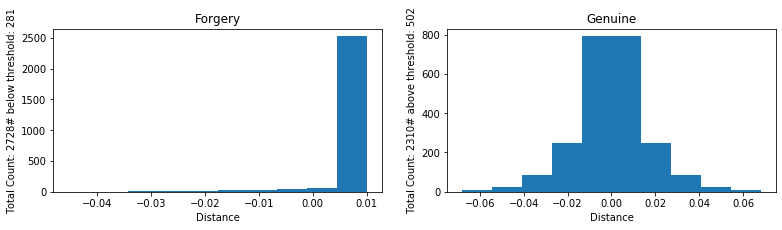

In [39]:
threshold = 0.01

df4_f = df3_f.copy(deep=True)
df4_f["Diff"] = df4_f["Diff"].map(lambda x: x if  x < threshold else threshold)

plt.figure(figsize=(20, 3))

plt.subplot(131)
plt.title('Forgery')
plt.xlabel("Distance")
plt.ylabel("Total Count: " + str(len(df4_f)) + "# below threshold: " + str(len(df3_f[df4_f.Diff < threshold ])))
plt.hist(df4_f["Diff"])

# df3_g = df2[df2.isGenuine==1]["Diff"]*10  #*0.0001
# df4_g = [(d if d < threshold else threshold) for d in df3_g]#0.0000006]

plt.subplot(132)
plt.title('Genuine')
plt.xlabel("Distance")
plt.ylabel("Total Count: " + str(len(df3_g)) + "# above threshold: " + str(len(df3_g[df3_g.Diff > threshold ])))
plt.hist(df3_g["Diff"])

In [40]:
df2["Forgery"] =  [1 if d==0 else 0 for d in df2["isGenuine"].values]
df2.corr() 

/opt/conda/envs/springboard/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Diff,isGenuine,Forgery
Diff,1.000000,-0.534244,0.534244
isGenuine,-0.534244,1.000000,-1.000000
Forgery,0.534244,-1.000000,1.000000


In [ ]:
threshold = 0.9925

df4_f["ToCompare"] = df[df.isGenuine==0]["ToCompare"]
df4_f["ToCompare"] = df4_f["ToCompare"].map(lambda x: x if  x > threshold else threshold-0.01)

In [ ]:
df3_g = df[(df.isGenuine == 1)]
df4_g = df3_g.copy(deep=True)
df4_g["Pos"] = df3_g["Pos"].map(lambda x: x if  x > threshold else (threshold-0.001))

In [ ]:
plt.figure(figsize=(20, 3))

plt.subplot(131)
plt.title('Forgery')
plt.xlabel("Distance")
plt.ylabel("Total Count: " + str(len(df3_f)) + "# below threshold: " + str(len(df3_f[df4_f.ToCompare > threshold ])))
plt.hist(df4_f["ToCompare"])

# df3_g = df2[df2.isGenuine==1]["Diff"]*10  #*0.0001
# df4_g = [(d if d < threshold else threshold) for d in df3_g]#0.0000006]

plt.subplot(132)
plt.title('Genuine')
plt.xlabel("Distance")
plt.ylabel("Total Count: " + str(len(df3_g)) + "# above threshold: " + str(len(df3_g[df3_g.Pos < threshold ])))
plt.hist(df4_g["Pos"])